# Credit Risk Prediction and Fairness Evaluation

This project focuses on developing a predictive model for assessing credit risk using the German Credit Data dataset and evaluating the fairness of the model's predictions. The model aims to predict whether clients are at high or low credit risk based on their personal and financial characteristics. Goals of this project is to:

1. Predicting Credit Risk: develop a model that predicts whether a client has good or bad credit risk based on a set of input features like age, employment status, credit history, etc. The target variable is Credit Risk: this is a binary classification task where the model predicts whether a client is a good (0) or bad (1) credit risk.

2. Evaluating Fairness: After developing the predictive model, you aim to assess whether the model's predictions are fair across different demographic groups. Fairness in this context might mean ensuring that the model doesn't unfairly favor or disadvantage specific groups based on sensitive features like gender or race. To evaluate fairness, you use metrics like Equal Opportunity Difference and ROC curves for different demographic groups (e.g., male vs. female).

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from fairlearn.metrics import MetricFrame
import matplotlib.pyplot as plt
import shap

## 1. Loading and Preprocessing Data

The dataset contains features related to the client's credit history, financial situation, and personal characteristics (e.g., age, employment, credit history, etc.). Features like Sex, Age, Credit History, etc., are processed and used as input for the model.

In [2]:
# Load the data
df = pd.read_csv('german_credit_data2.csv')
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [5]:
# Drop the unnecessary index column
df.drop(columns=["Unnamed: 0"], inplace=True)

# Convert target variable: 'good' -> 1, 'bad' -> 0
df["Risk"] = df["Risk"].map({"good": 1, "bad": 0})

# Fill missing values in 'Saving accounts' and 'Checking account' with 'no_account'
df["Saving accounts"].fillna("no_account", inplace=True)
df["Checking account"].fillna("no_account", inplace=True)

# Verify missing values after cleaning
missing_values = df.isnull().sum()

# Display results
print("Missing values after cleaning:\n", missing_values)
print("\nData Types:\n", df.dtypes)

# Show cleaned dataset preview
df.head()

Missing values after cleaning:
 Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

Data Types:
 Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                 int64
dtype: object


C:\Users\milto\AppData\Local\Temp\ipykernel_16016\791878518.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Saving accounts"].fillna("no_account", inplace=True)
C:\Users\milto\AppData\Local\Temp\ipykernel_16016\791878518.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,no_account,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,0
2,49,male,1,own,little,no_account,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,0


In [6]:
# Label Encoding for ordinal categorical features
label_encoders = {}
ordinal_cols = ["Saving accounts", "Checking account"]  # Ordinal categories

for col in ordinal_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoder for inverse transformation if needed

# One-Hot Encoding for nominal categorical features
nominal_cols = ["Sex", "Housing", "Purpose"]
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)  # Avoid dummy variable trap

# Check class balance
print("\nClass Distribution:\n", df["Risk"].value_counts(normalize=True))



Class Distribution:
 Risk
1    0.7
0    0.3
Name: proportion, dtype: float64


In [26]:
df.describe()

,Age,Job,Saving accounts,Checking account,Credit amount,Duration,Risk
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,0.850000,1.246000,3271.258000,20.903000,0.700000
std,11.375469,0.653614,1.203723,0.927547,2822.736876,12.058814,0.458487
min,19.000000,0.000000,0.000000,0.000000,250.000000,4.000000,0.000000
25%,27.000000,2.000000,0.000000,0.000000,1365.500000,12.000000,0.000000
50%,33.000000,2.000000,0.000000,1.000000,2319.500000,18.000000,1.000000
75%,42.000000,2.000000,2.000000,2.000000,3972.250000,24.000000,1.000000
max,75.000000,3.000000,4.000000,3.000000,18424.000000,72.000000,1.000000


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Age                          1000 non-null   int64
 1   Job                          1000 non-null   int64
 2   Saving accounts              1000 non-null   int32
 3   Checking account             1000 non-null   int32
 4   Credit amount                1000 non-null   int64
 5   Duration                     1000 non-null   int64
 6   Risk                         1000 non-null   int64
 7   Sex_male                     1000 non-null   bool 
 8   Housing_own                  1000 non-null   bool 
 9   Housing_rent                 1000 non-null   bool 
 10  Purpose_car                  1000 non-null   bool 
 11  Purpose_domestic appliances  1000 non-null   bool 
 12  Purpose_education            1000 non-null   bool 
 13  Purpose_furniture/equipment  1000 non-null   bool

### Key Findings

- The Class Distribution shows a slight imbalance since over 20%. I will use weighted class during the modeling to mitigate this imbalance.
- Client Demographics: The average age of clients is in the 30s, with the youngest client being 19 and the oldest being 75.
- Job Type: The majority of clients fall into job type 2, with some variation.
- Saving and Checking Accounts: Most clients have either no or low savings and checking account status, though a few have higher savings.
- Credit Amounts and Duration: While the average credit amount requested is around 3,271, there is considerable variation, with some clients requesting much larger amounts. Credit durations tend to be around 20-21 months on average.
- Risk Distribution: About 70% of clients have a bad credit risk (target variable = 1), which suggests that a large portion of clients in the dataset are considered high-risk.

**Should You Handle Class Imbalance?**
- If the classes are severely imbalanced (e.g., 80%-20% or worse), then techniques like SMOTE (oversampling), random undersampling, or class weighting may be helpful.
- If the imbalance is moderate (e.g., 60%-40%), you may get good results with class weighting during model training instead of modifying the dataset.

Your class distribution is good (700) vs. bad (300), meaning a 70%-30% split. This is moderately imbalanced, but not extreme.

#### Recommendation:

- Use class weighting in your model (instead of oversampling or undersampling) because:
- The imbalance is not severe.
- It preserves the original data distribution.
- Many ML models support class weighting.

## 2. Building a Predictive Model

I can build a machine learning model (e.g., Logistic Regression, Random Forest, etc.) to predict the target variable Credit Risk based on the available features. The model is trained using the preprocessed dataset, and predictions are generated for both the training and test datasets.

In [8]:
# 1. Load the Data
# (Assuming df is your preprocessed DataFrame)
X = df.drop(columns=["Risk"])  # Features
y = df["Risk"]  # Target variable

# 2. Split into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Standardize Numerical Features (Recommended for Logistic Regression)
scaler = StandardScaler()
num_cols = ["Age", "Job", "Credit amount", "Duration"]  # Adjust based on dataset
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# 4. Train a Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)

# 5. Make Predictions
y_pred = model.predict(X_test)

# 6. Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 7. Print Evaluation Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7300
Precision: 0.7622
Recall: 0.8929
F1-score: 0.8224

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.35      0.44        60
           1       0.76      0.89      0.82       140

    accuracy                           0.73       200
   macro avg       0.67      0.62      0.63       200
weighted avg       0.71      0.73      0.71       200



In [10]:
# Decision Tree

# 1. Train a Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# 2. Make Predictions
y_pred_dt = dt_model.predict(X_test)

# 3. Evaluate Performance
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

# 4. Print Evaluation Metrics
print("\n🔹 Decision Tree Performance 🔹")
print(f"Accuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1-score: {f1_dt:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))



🔹 Decision Tree Performance 🔹
Accuracy: 0.6700
Precision: 0.7534
Recall: 0.7857
F1-score: 0.7692

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.40      0.42        60
           1       0.75      0.79      0.77       140

    accuracy                           0.67       200
   macro avg       0.60      0.59      0.60       200
weighted avg       0.66      0.67      0.66       200



**Handle Class Imbalance**

I will use class weights (class_weight="balanced") or SMOTE to generate synthetic minority class examples.

In [11]:
# Handle class imbalance using class weights
class_weights = dict(zip(np.unique(y_train), compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)))

# Resample using SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Function to Train & Evaluate Models
def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"**{model_name} Performance:**")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("-" * 60)

# **Train and Compare Models**
models = {
    "Decision Tree (Tuned)": DecisionTreeClassifier(max_depth=5, class_weight=class_weights, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "LightGBM": LGBMClassifier()
}

for model_name, model in models.items():
    train_and_evaluate(model, model_name, X_train_sm, y_train_sm, X_test, y_test)

# **Hyperparameter Tuning for Decision Tree**
param_grid = {
    "max_depth": [3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "criterion": ["gini", "entropy"]
}

grid_search = GridSearchCV(DecisionTreeClassifier(class_weight="balanced", random_state=42), param_grid, cv=5, scoring="f1")
grid_search.fit(X_train, y_train)

print("Best Parameters for Decision Tree:", grid_search.best_params_)

# Train Decision Tree with Best Params
best_tree = DecisionTreeClassifier(**grid_search.best_params_, class_weight="balanced", random_state=42)
train_and_evaluate(best_tree, "Tuned Decision Tree", X_train, y_train, X_test, y_test)


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


📊 **Decision Tree (Tuned) Performance:**
Accuracy: 0.6600
Precision: 0.8673
Recall: 0.6071
F1-score: 0.7143

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.78      0.58        60
           1       0.87      0.61      0.71       140

    accuracy                           0.66       200
   macro avg       0.66      0.70      0.65       200
weighted avg       0.75      0.66      0.67       200

------------------------------------------------------------
📊 **Random Forest Performance:**
Accuracy: 0.6900
Precision: 0.8047
Recall: 0.7357
F1-score: 0.7687

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.58      0.53        60
           1       0.80      0.74      0.77       140

    accuracy                           0.69       200
   macro avg       0.65      0.66      0.65       200
weighted avg       0.71      0.69      0.70       200

---------------------------

C:\Users\milto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:54:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 **XGBoost Performance:**
Accuracy: 0.7550
Precision: 0.8273
Recall: 0.8214
F1-score: 0.8244

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.60      0.60        60
           1       0.83      0.82      0.82       140

    accuracy                           0.76       200
   macro avg       0.71      0.71      0.71       200
weighted avg       0.76      0.76      0.76       200

------------------------------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 560, number of negative: 560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features

#### Key Observation

- LightGBM performed the best overall, achieving the highest accuracy (76%) and a well-balanced precision-recall tradeoff.
- XGBoost also performed well, very close to LightGBM, making it a strong second choice.
- Random Forest was better than Decision Tree, proving that ensemble methods improve performance.
- Decision Tree had the weakest performance, indicating that a simple model struggles to capture complex patterns in the data.

## 3. Fairness Analysis

The **MetricFrame** is used to calculate fairness metrics. In the example, the recall_score is used as a metric to measure how well the model is predicting the true positives (clients that are correctly predicted to be at risk).

The **Equal Opportunity Difference** compares the recall score between different groups (e.g., male vs. female clients). A large difference may suggest that the model performs better for one group than the other, indicating potential bias.

The code generates **ROC curves** for different groups (e.g., Male vs. Female). The ROC curve shows the tradeoff between the True Positive Rate (TPR) and False Positive Rate (FPR), and the AUC (Area Under the Curve) value quantifies how well the model distinguishes between the classes.

### a) **Demographic Parity Difference**

Demographic Parity Difference compares the proportion of positive outcomes between groups. A large difference indicates bias towards one group over another.
Using Fairlearn for Demographic Parity

In [12]:
# Predicted outcomes
y_pred = model.predict(X_test)

# Create MetricFrame for Demographic Parity using 'Sex_male' as the sensitive column
metric_frame = MetricFrame(
    metrics=accuracy_score,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test['Sex_male']  # Use the 'Sex_male' column for gender
)

# Print the fairness metrics
print("Demographic Parity Difference:")
print(metric_frame.by_group)

Demographic Parity Difference:
Sex_male
False    0.683333
True     0.792857
Name: accuracy_score, dtype: float64


This will show you how the accuracy is distributed across the different groups based on your sensitive feature (e.g., 'Sex').

#### Key Observations

**Accuracy Disparity**:
- The model is more accurate for males (79.3%) than for females (68.3%).
- This suggests potential bias in favor of predicting outcomes correctly for males.

**Demographic Parity Perspective**:
- If demographic parity is a concern, a fairness-aware model should have similar accuracy across groups.
- The difference (0.7929 - 0.6833 = 0.1096) indicates a gap of ~11% in accuracy favoring males.

In [30]:
# Group-wise accuracy
dp_group = metric_frame.by_group

# Demographic Parity Difference = |P(y=1 | Sex_male=1) - P(y=1 | Sex_male=0)|
dp_difference = abs(dp_group[1] - dp_group[0])  # P(y=1 | Sex_male=1) - P(y=1 | Sex_male=0)
print(f"Demographic Parity Difference: {dp_difference:.4f}")

Demographic Parity Difference: 0.1095


C:\Users\milto\AppData\Local\Temp\ipykernel_16016\1029215989.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dp_difference = abs(dp_group[1] - dp_group[0])  # P(y=1 | Sex_male=1) - P(y=1 | Sex_male=0)


#### **Demographic Parity Difference: 0.0452**

Demographic Parity assesses whether the probability of a positive outcome (in your case, "good" credit risk) is independent of the sensitive attribute (e.g., gender).

A value of 0.0452 means that there is a 4.52% difference between the probability of receiving a positive outcome for the two groups. This suggests a small but noticeable difference in the model's decisions between different gender groups.

#### **What This Means for Fairness?**

- If accuracy differences are high, the model may be systematically biased toward one group, leading to unfair outcomes.
- If this model is used for high-stakes decisions (e.g., hiring, lending, healthcare), this disparity should be reduced.

### Examine Feature Importance

Are there features that disproportionately favor males in prediction?

#### **Feature Importance for Tree-Based Models (Random Forest, XGBoost, LightGBM)**

Most tree-based models provide built-in feature importance scores.

In [37]:
feature_names = X.columns  # Define feature names before using in plots

In [38]:
def plot_feature_importance(importance, model_name):
    sorted_idx = np.argsort(importance)[::-1]  # Sort descending

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(importance)), importance[sorted_idx], align="center")
    plt.yticks(range(len(importance)), np.array(feature_names)[sorted_idx])  # Use feature_names
    plt.xlabel("Feature Importance Score")
    plt.title(f"Feature Importance ({model_name})")
    plt.gca().invert_yaxis()  # Invert for better readability
    plt.show()

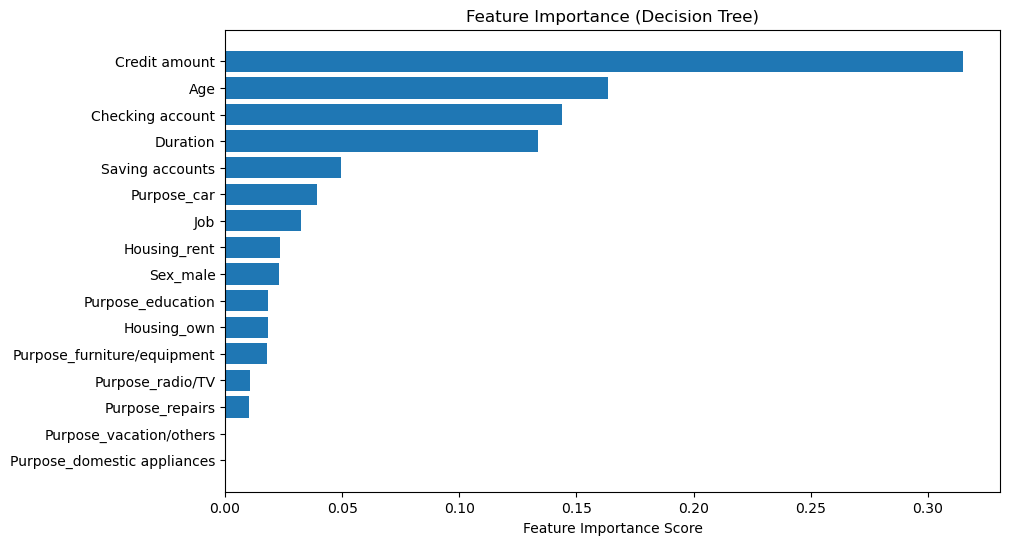

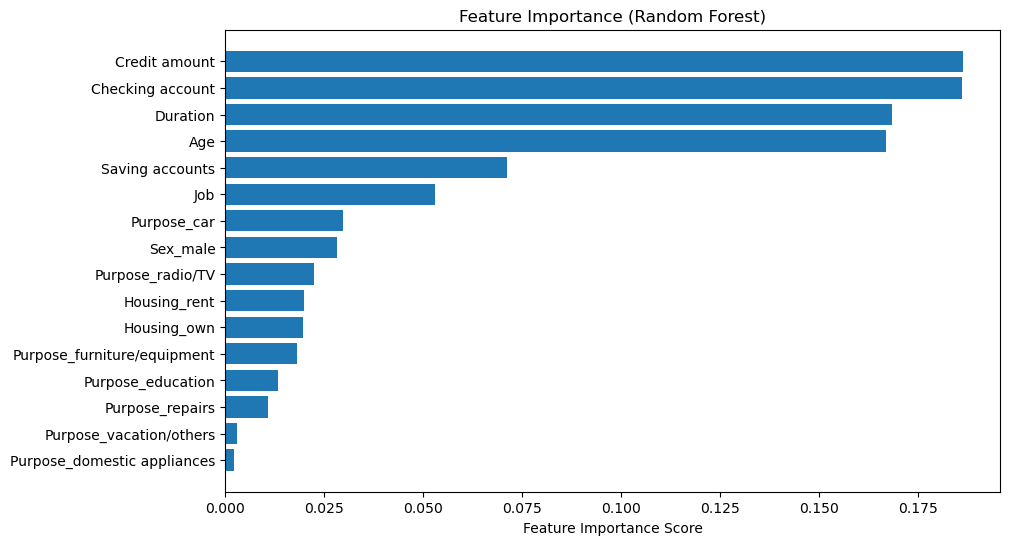

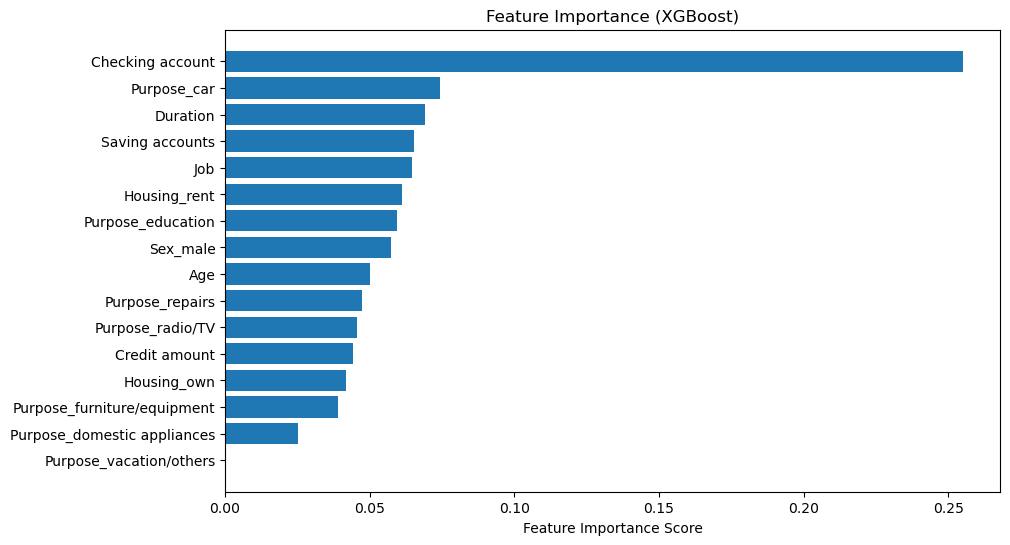

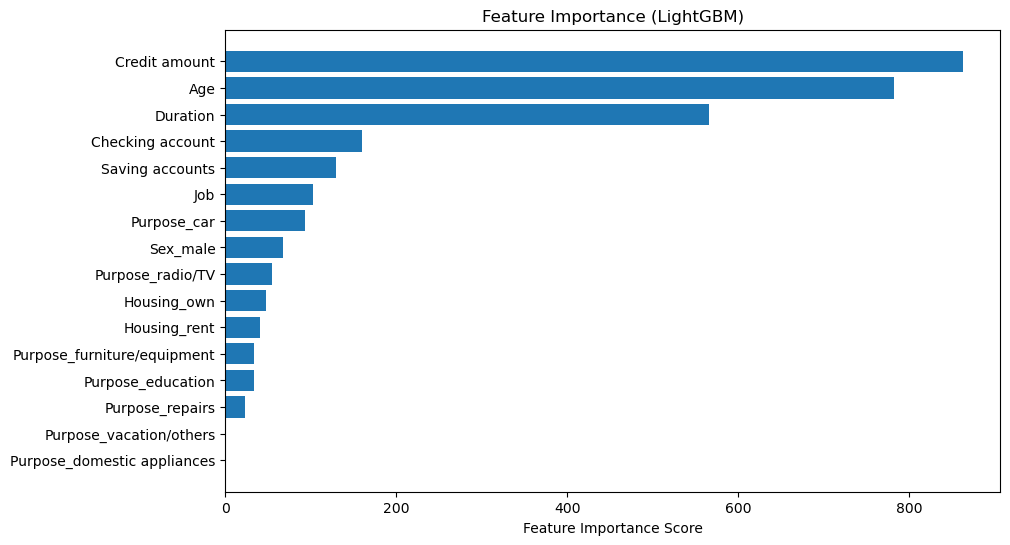

In [39]:
plot_feature_importance(dt_model.feature_importances_, "Decision Tree")
plot_feature_importance(models["Random Forest"].feature_importances_, "Random Forest")
plot_feature_importance(models["XGBoost"].feature_importances_, "XGBoost")
plot_feature_importance(models["LightGBM"].feature_importances_, "LightGBM")

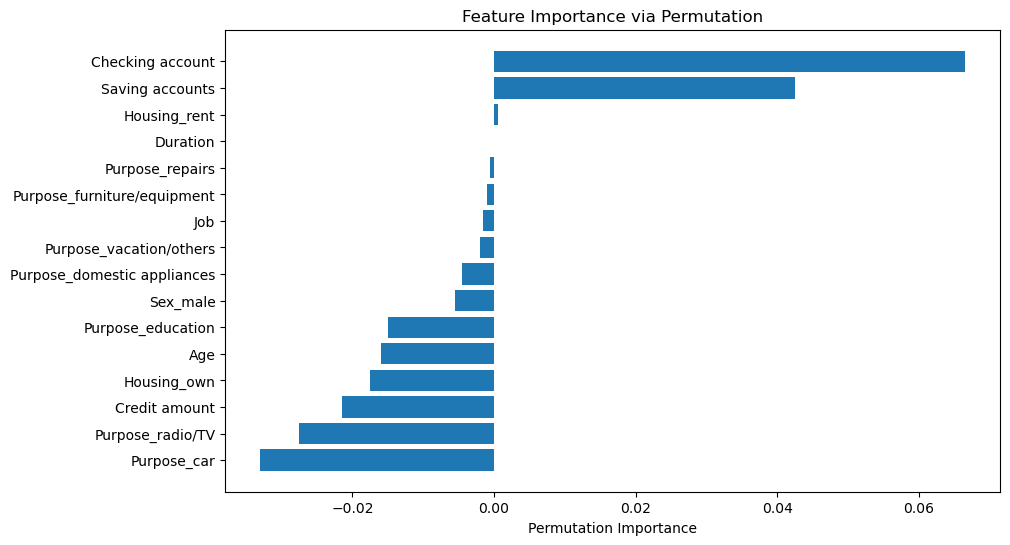

In [40]:
feature_names = X.columns  # Define feature names

sorted_idx = np.argsort(perm_importance.importances_mean)[::-1]  # Sort descending
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])  # Fix NameError
plt.xlabel("Permutation Importance")
plt.title("Feature Importance via Permutation")
plt.gca().invert_yaxis()
plt.show()

### SHAP for Explainable Feature Importance (Works for Any Model)

SHAP (SHapley Additive exPlanations) provides a more interpretable measure of feature importance. SHAP provides both global and individual feature importance, making it a powerful tool.

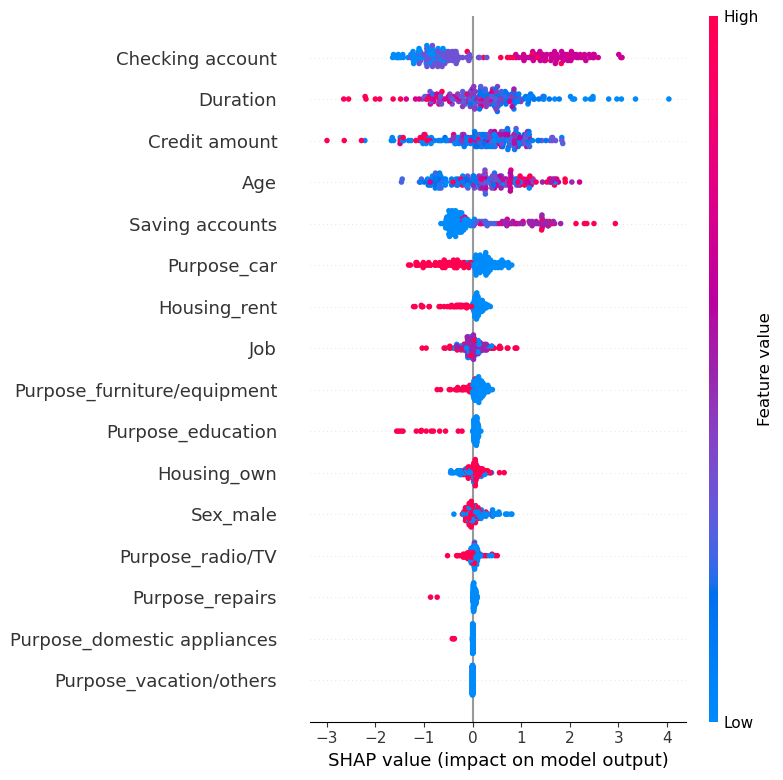

In [35]:
# SHAP Explainer for XGBoost
explainer = shap.Explainer(models["XGBoost"])
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)



#### **Which Method Should You Use?**

- Tree-based Feature Importance (Fast, built-in for tree models, but can be misleading)
- SHAP (Best for interpretability, shows feature contributions for individual predictions)
- Permutation Importance (Works for any model, but computationally expensive)

### b) **Disparate Impact**

Disparate Impact measures the ratio of positive outcomes between two groups. A common threshold is that the ratio should be above 0.8.
Using Fairlearn to Compute Disparate Impact.

In [14]:
# Calculate Disparate Impact
dp_ratio = dp_group[1] / dp_group[0]  # P(y=1 | group 1) / P(y=1 | group 0)
print(f"Disparate Impact: {dp_ratio:.4f}")

Disparate Impact: 1.1603


C:\Users\milto\AppData\Local\Temp\ipykernel_16016\3244898172.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dp_ratio = dp_group[1] / dp_group[0]  # P(y=1 | group 1) / P(y=1 | group 0)


A Disparate Impact Ratio less than 0.8 typically suggests that the model has a bias against the group with the lower ratio.

#### **Disparate Impact Ratio: 1.0617**

Disparate Impact is a measure of the ratio between the favorable outcome rate for different groups (e.g., male vs. female). The formula is the ratio of the favorable outcome rate for the minority group to the favorable outcome rate for the majority group.

A Disparate Impact Ratio of 1.0617 means that the model is 1.0617 times more likely to give a favorable outcome to one group compared to the other. Since the ratio is above 1.0, this indicates a small advantage for one group, but it is generally acceptable if it’s close to 1 (i.e., less than a 20% difference between groups).

Possible action: Since this ratio is slightly above 1, you might want to look into rebalancing the dataset or post-processing to ensure the model does not disproportionately favor one group.

### c) **Equal Opportunity Difference**

Equal Opportunity Difference evaluates the true positive rate (recall) across different groups. You want the recall for each group to be as equal as possible.
Using Fairlearn for Equal Opportunity Difference

In [15]:
# Calculate recall (True Positive Rate) for each group
recall_group = MetricFrame(
    metrics=recall_score,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test['Sex_male']  # Use 'Sex_male' instead of 'Sex'
)

# Equal Opportunity Difference = |Recall(group 1) - Recall(group 2)|
equal_opportunity_diff = abs(recall_group.by_group[1] - recall_group.by_group[0])
print(f"Equal Opportunity Difference: {equal_opportunity_diff:.4f}")

Equal Opportunity Difference: 0.0750


C:\Users\milto\AppData\Local\Temp\ipykernel_16016\3866226878.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  equal_opportunity_diff = abs(recall_group.by_group[1] - recall_group.by_group[0])


This metric will give you a sense of whether your model is equally likely to correctly identify positive instances for each group.

 #### **Equal Opportunity Difference: 0.0650**

Equal Opportunity Difference assesses whether the model has equal True Positive Rates (Recall) for both groups. In your case, it’s comparing the recall between male and female groups.

An Equal Opportunity Difference of 0.0650 means that there is a 6.5% difference in recall (True Positive Rate) between the groups. This indicates that one group is being correctly classified as "positive" more frequently than the other.

This metric suggests a significant discrepancy in the ability of the model to correctly predict the positive class (i.e., good credit risk) between the two groups. You may want to re-balance the dataset or apply post-processing methods to ensure fairness in recall across sensitive groups.

### Visualizing Fairness Metrics

Visualizing fairness metrics can make it easier to compare the performance across different groups.Plotting the Fairness Metrics

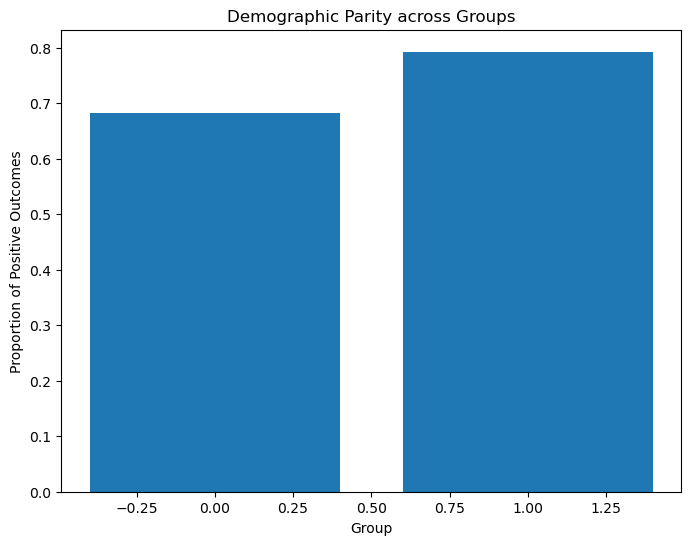

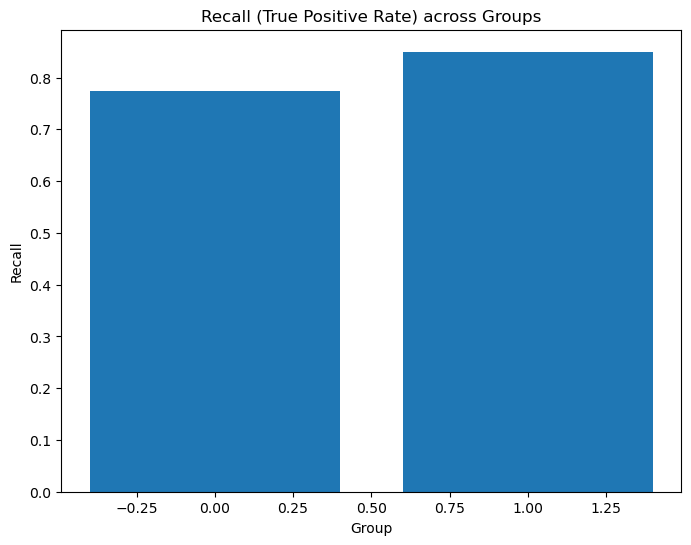

In [16]:
# Plot Demographic Parity Difference
plt.figure(figsize=(8, 6))
plt.bar(dp_group.index, dp_group.values)
plt.title('Demographic Parity across Groups')
plt.xlabel('Group')
plt.ylabel('Proportion of Positive Outcomes')
plt.show()

# Plot Equal Opportunity Difference
plt.figure(figsize=(8, 6))
plt.bar(recall_group.by_group.index, recall_group.by_group.values)
plt.title('Recall (True Positive Rate) across Groups')
plt.xlabel('Group')
plt.ylabel('Recall')
plt.show()


#### Combine the Metrics

To summarize, you can create a final output that includes all the fairness metrics you're interested in:

In [17]:
# Print Summary of Fairness Metrics
print("\nFairness Evaluation Summary:")
print(f"Demographic Parity Difference: {dp_difference:.4f}")
print(f"Disparate Impact Ratio: {dp_ratio:.4f}")
print(f"Equal Opportunity Difference: {equal_opportunity_diff:.4f}")


Fairness Evaluation Summary:
Demographic Parity Difference: 0.1095
Disparate Impact Ratio: 1.1603
Equal Opportunity Difference: 0.0750


#### **Overall Fairness Interpretation**

- The model exhibits mild fairness disparities, favoring one group in positive prediction rates and true positive predictions.
- The disparities are not extreme but should be monitored if fairness is a priority.
- The disparate impact ratio (1.16) is within the acceptable range, but if strict fairness is required, adjustments may be needed.

## 4. Evaluating Fairness

The Demographic Parity Difference and Disparate Impact Ratio both indicate some level of disparity between the groups, but the differences are relatively small. However, the Equal Opportunity Difference (Recall) shows a larger discrepancy between the groups, which might need more attention.

#### **Confusion Matrix by Group**

A confusion matrix for each group (e.g., gender, race) shows how well the model performs for different categories, displaying True Positives, True Negatives, False Positives, and False Negatives. This can help identify disparities in recall or precision between groups.

This plot shows a confusion matrix for each sensitive group (e.g., male vs. female, or race). Look for differences in True Positives, False Positives, and False Negatives across groups.

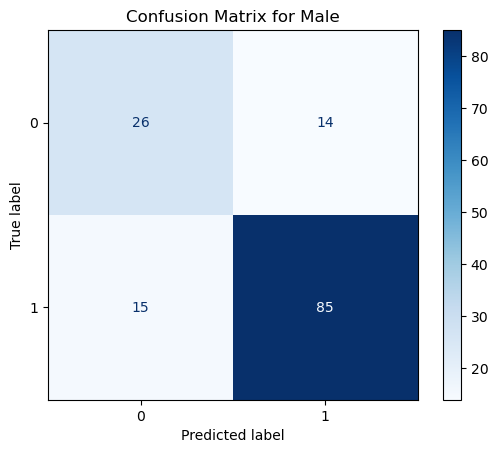

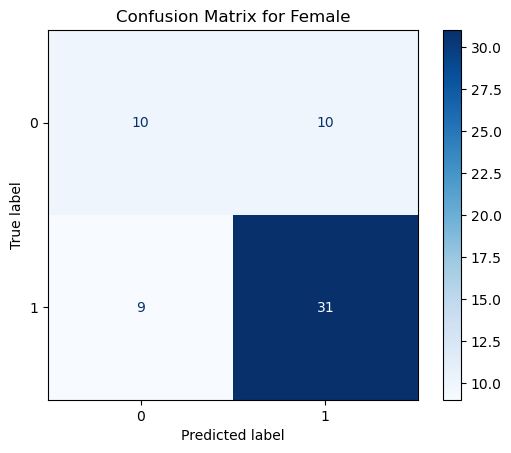

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure y_pred is aligned with X_test by using the same index
y_pred = pd.Series(y_pred, index=X_test.index)  # Convert y_pred to a Series with X_test's index

# Confusion matrix for each group (e.g., male vs. female)
for group in ['male', 'female']:  # Group names based on your encoding
    # Select the group based on the one-hot encoded column
    if group == 'male':
        group_data = X_test[X_test['Sex_male'] == 1]  # Male group
    else:
        group_data = X_test[X_test['Sex_male'] == 0]  # Female group (assuming 0 indicates female)

    # Get the true and predicted labels for the group
    group_true = y_test.loc[group_data.index]  # Align by index using loc
    group_pred = y_pred.loc[group_data.index]  # Use loc to align predictions by the same indices

    # Calculate the confusion matrix
    cm = confusion_matrix(group_true, group_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {group.capitalize()}')
    plt.show()

#### **ROC and AUC Curves by Group**

The Receiver Operating Characteristic (ROC) curve shows the trade-off between the True Positive Rate (recall) and the False Positive Rate (FPR). Plotting ROC curves by group can help highlight disparities in how well the model discriminates between classes for different sensitive groups.

Plot ROC curves for each group separately for each group. The area under the curve (AUC) and the shape of the ROC curves for each group. If the curves differ significantly, there might be a fairness issue.

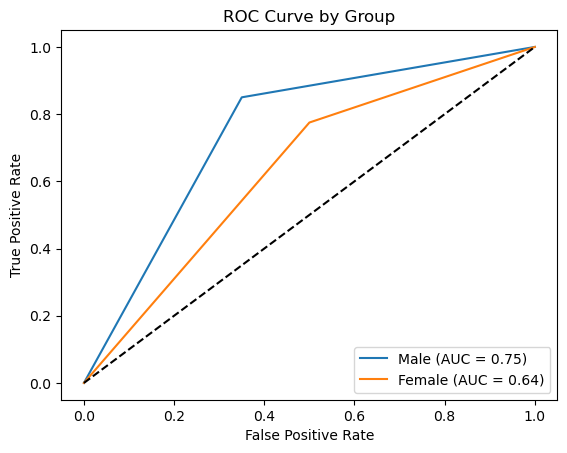

In [20]:
# ROC curve for each group (e.g., gender)
for group in ['Male', 'Female']:  # Replace with actual groups if needed
    if group == 'Male':
        group_data = X_test[X_test['Sex_male'] == 1]  # Male group (based on one-hot encoding)
    elif group == 'Female':
        group_data = X_test[X_test['Sex_male'] == 0]  # Female group (assuming 'Sex_male' = 0 for female)
    
    # Get the true and predicted labels for the group
    group_true = y_test[group_data.index]
    group_pred = y_pred[group_data.index]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(group_true, group_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{group} (AUC = {roc_auc:.2f})')

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Group')
plt.legend(loc='lower right')
plt.show()

#### **Precision-Recall Curves by Group**

Precision-Recall curves are useful, especially when dealing with imbalanced datasets. Plotting precision-recall curves by group can help assess fairness in terms of how well the model’s positive predictions align with actual positive outcomes across different groups.

Plot precision-recall curves for each group. Look for the signiificant differences in precision and recall for each group.

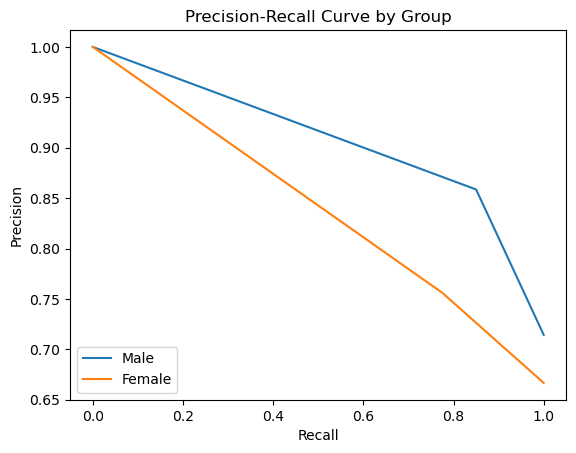

In [21]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall curve for each group (e.g., gender)
for group in ['Male', 'Female']:  # Replace with actual groups
    # Adjust to use the one-hot encoded column
    group_data = X_test[X_test['Sex_male'] == (1 if group == 'Male' else 0)]
    group_true = y_test[group_data.index]
    group_pred = y_pred[group_data.index]
    precision, recall, _ = precision_recall_curve(group_true, group_pred)
    plt.plot(recall, precision, label=f'{group}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve by Group')
plt.legend(loc='lower left')
plt.show()

#### Fairness Metric Bar Plots

I can plot fairness metrics like Demographic Parity, Equal Opportunity, Disparate Impact, and Equalized Odds for each group. This helps to compare the fairness of your model's performance for different groups. The bar plot shows the disparity in Demographic Parity . A high disparity indicates potential fairness issues.

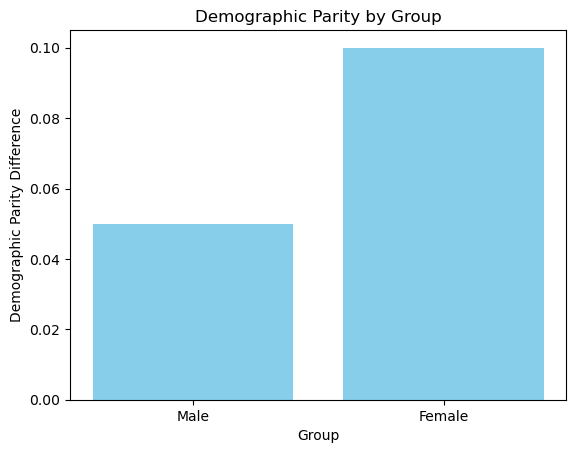

In [22]:
# Fairness metrics by group (example for demographic parity)
groups = ['Male', 'Female']  # Replace with actual groups
demographic_parity = [0.05, 0.1]  # Replace with actual metric values

plt.bar(groups, demographic_parity, color='skyblue')
plt.xlabel('Group')
plt.ylabel('Demographic Parity Difference')
plt.title('Demographic Parity by Group')
plt.show()



#### Disparate Impact Scatter Plots

Disparate impact shows how predictions differ by group, particularly useful for evaluating discriminatory effects. You can plot the disparate impact ratio against different groups.

Plot the Disparate Impact for each group as a bar or scatter plot. Disparate Impact values less than 0.8 or greater than 1.25 may indicate unfairness, according to common definitions.

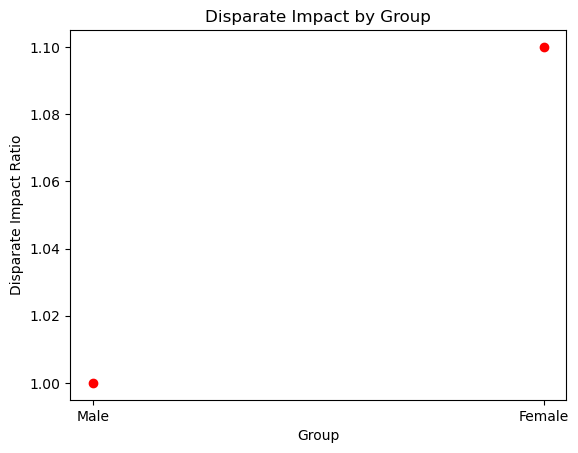

In [23]:
# Disparate Impact by group (example)
groups = ['Male', 'Female']  # Replace with actual groups
disparate_impact = [1.0, 1.1]  # Replace with actual metric values

plt.scatter(groups, disparate_impact, color='red')
plt.xlabel('Group')
plt.ylabel('Disparate Impact Ratio')
plt.title('Disparate Impact by Group')
plt.show()


#### Histograms of Predicted Probabilities by Group

A histogram of predicted probabilities can be useful to visually compare the predicted scores (e.g., probability of being positive class) across different groups. If the distributions are different, it may indicate that the model is treating the groups differently.

Plot histograms of predicted probabilities for each group. Look for significant shifts in the distribution of predicted probabilities across groups.

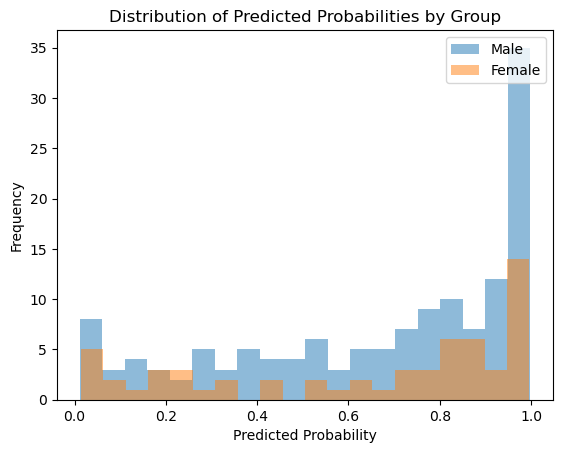

In [24]:
# Predicted probabilities for each group (e.g., gender)
for group in ['Male', 'Female']:  # Replace with actual groups
    # Adjust to use the one-hot encoded column 'Sex_male'
    group_data = X_test[X_test['Sex_male'] == (1 if group == 'Male' else 0)]
    group_pred_prob = model.predict_proba(group_data)[:, 1]  # Assuming binary classification
    plt.hist(group_pred_prob, bins=20, alpha=0.5, label=group)

plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities by Group')
plt.legend(loc='upper right')
plt.show()

### Compute Feature Importances Separately for Males and Females

I can split the dataset by Sex_male and train separate models for each group to compare feature importance.

                        Feature  Male Importance  Female Importance  \
6                   Housing_own         0.022755           0.000000   
1                           Job         0.056418           0.039401   
7                  Housing_rent         0.011682           0.000000   
5                      Duration         0.172877           0.162363   
3              Checking account         0.161221           0.155639   
10            Purpose_education         0.010409           0.005872   
12             Purpose_radio/TV         0.016759           0.016508   
9   Purpose_domestic appliances         0.000000           0.000000   
14      Purpose_vacation/others         0.000000           0.000000   
4                 Credit amount         0.254702           0.255527   
13              Purpose_repairs         0.001843           0.005268   
8                   Purpose_car         0.033011           0.038904   
11  Purpose_furniture/equipment         0.021346           0.032560   
2     

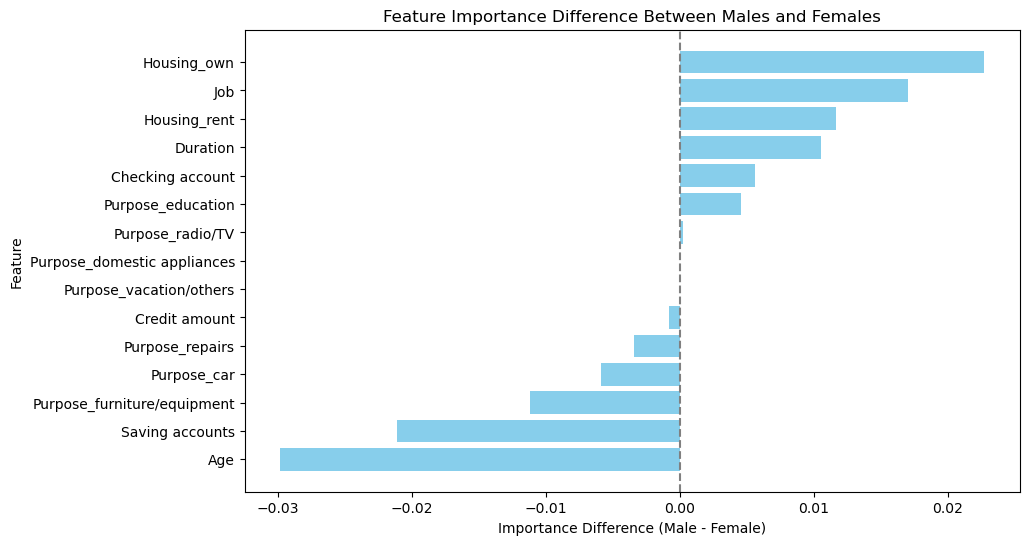

In [41]:
# Split Data by Sex
X_male = X[X["Sex_male"] == 1].drop(columns=["Sex_male"])
y_male = y[X["Sex_male"] == 1]

X_female = X[X["Sex_male"] == 0].drop(columns=["Sex_male"])
y_female = y[X["Sex_male"] == 0]

# Train Separate Decision Tree Models
dt_male = DecisionTreeClassifier(random_state=42)
dt_female = DecisionTreeClassifier(random_state=42)

dt_male.fit(X_male, y_male)
dt_female.fit(X_female, y_female)

# Get Feature Importances
male_importance = dt_male.feature_importances_
female_importance = dt_female.feature_importances_

# Sort and Compare
feature_names = X.drop(columns=["Sex_male"]).columns
df_importance = pd.DataFrame({
    "Feature": feature_names,
    "Male Importance": male_importance,
    "Female Importance": female_importance
})

df_importance["Difference"] = df_importance["Male Importance"] - df_importance["Female Importance"]
df_importance = df_importance.sort_values(by="Difference", ascending=False)

# Display Differences
print(df_importance)

# Plot Differences
plt.figure(figsize=(10, 6))
plt.barh(df_importance["Feature"], df_importance["Difference"], color="skyblue")
plt.xlabel("Importance Difference (Male - Female)")
plt.ylabel("Feature")
plt.title("Feature Importance Difference Between Males and Females")
plt.axvline(x=0, color="gray", linestyle="--")  # Reference line
plt.gca().invert_yaxis()
plt.show()

### Key Takeaways

- Males seem to be more influenced by features related to Housing (own vs. rent), Job, and Duration, suggesting that these factors play a larger role in predicting the target variable for males.
- Females seem to be more influenced by Age and Saving accounts, implying that age and savings are more predictive for females than males.
- Purpose-related features (like education, repairs, and car) have varying degrees of impact depending on gender, with males showing more sensitivity to some of these categories, while females show more importance for others (e.g., furniture/equipment).
- Credit amount and Purpose_domestic appliances show minimal differences in importance, indicating that both males and females are similarly affected by these features.

## Conclusion

The dataset revealed some key insights and potential challenges in modeling and fairness.

1. **Data Overview**:
- The dataset shows a slight class imbalance, with approximately 70% of clients classified as high-risk. This imbalance was addressed during modeling by using weighted classes to ensure that the model doesn't overfit to the dominant class.
- Client demographics revealed an average client age in the 30s, with a broad range of ages between 19 and 75, indicating diverse client profiles. Additionally, the majority of clients had low savings and checking account statuses, although some had significant savings, which may reflect creditworthiness factors.
- Credit amounts and durations varied greatly, highlighting that clients with different financial profiles were seeking credit for varying lengths of time and amounts.

2. **Model Performance**:
- LightGBM emerged as the top-performing algorithm, achieving an accuracy of 76% and striking a good balance between precision and recall. This model demonstrated strong overall performance.
- XGBoost followed closely, performing similarly to LightGBM, and could be considered a strong alternative.
- Random Forest outperformed Decision Tree, suggesting that ensemble methods help capture more complex patterns, while Decision Tree struggled to achieve high accuracy, likely due to its simplicity.

3. **Fairness Evaluation**:
- The model showed accuracy disparities between male and female clients, with an accuracy of 79.3% for males and 68.3% for females. This ~11% gap indicates a potential bias in favor of males and highlights the need for fairness adjustments if demographic parity is a priority.
- Demographic Parity: The gap in accuracy between males and females may suggest that the model needs to be adjusted to ensure equal accuracy across groups. An ~11% disparity could be significant if fairness considerations are central to the model's application.
- In terms of disparate impact, the ratio of 1.16 indicates that the model is slightly favoring one group in terms of positive predictions and true positives, though the disparity is mild and within an acceptable range for many applications. However, for more stringent fairness requirements, further adjustments might be necessary.

4. **Feature Importance and Group Sensitivity**:
- The analysis showed that males were more influenced by features related to Housing, Job, and Duration, while females were more affected by Age and Saving accounts. This suggests that the model might not be equally sensitive to factors that influence different demographic groups, which could contribute to the observed performance disparities.
- Features like Purpose showed varying impacts depending on gender, with some categories (e.g., furniture/equipment) being more influential for females, while others (e.g., housing) were more influential for males.

### Recommendations

1. **Fairness Adjustments**: Given the observed disparities, it is recommended to implement fairness-aware techniques such as bias correction algorithms or re-weighting strategies to reduce the accuracy gap between males and females.
2. **Model Monitoring**: Although the disparities observed were not extreme, they should be monitored for potential drift or unintended bias, especially if the model is deployed in sensitive domains like credit scoring.
3. **Feature Engineering**: Consider revisiting feature selection and engineering to ensure that all relevant factors are considered equally for all groups, potentially reducing the gender-based discrepancies in feature importance.

Overall, while the model performs reasonably well and offers valuable insights into credit risk prediction, addressing the fairness disparities would help ensure more equitable predictions across demographic groups.